In [1]:
import osmnx as ox, geopandas as gpd, time
%matplotlib inline
ox.config(use_cache=True, log_file=True, log_console=True, log_filename='get_every_us_urban_area_graph',
          data_folder='G:/Geoff/osmnx/urbanized-areas-usa', cache_folder='G:/Geoff/osmnx/cache/urbanized-areas-usa')

In [2]:
network_type = 'drive_service'
retain_all = True
buffer = False

## Load shapes

In [3]:
gdf = gpd.read_file('input_data/tl_2016_us_uac10').sort_values(by='ALAND10', ascending=True)
len(gdf)

3601

In [4]:
# remove the tiny "urban clusters" to retain only "urban areas"
urban_areas = gdf[~gdf['NAMELSAD10'].str.contains('Urban Cluster')]
len(urban_areas)

497

In [5]:
# tigerline data is epsg:4269, but osm uses epsg:4326, so project it
print(urban_areas.crs)
urban_areas = urban_areas.to_crs({'init':'epsg:4326'})
urban_areas.crs

{'init': 'epsg:4269'}


{'init': 'epsg:4326'}

In [6]:
urban_areas[['ALAND10', 'NAMELSAD10', 'GEOID10']].tail()

,ALAND10,NAMELSAD10,GEOID10
1593,4852285339,"Boston, MA--NH--RI Urbanized Area",09271
2546,5132095000,"Philadelphia, PA--NJ--DE--MD Urbanized Area",69076
3250,6325255332,"Chicago, IL--IN Urbanized Area",16264
3002,6850045152,"Atlanta, GA Urbanized Area",03817
2321,8937429045,"New York--Newark, NY--NJ--CT Urbanized Area",63217


In [7]:
# optionally buffer so streets that form the boundary don't get ignored
# but, buffering will mess up using ALAND for area as polygon area will capture nodes outside ALAND!
if buffer:
    buffer_dist = 50
    urban_areas.name = 'urban_areas'
    urban_areas_utm = ox.project_gdf(urban_areas)
    urban_areas_utm['geometry'] = urban_areas_utm['geometry'].buffer(buffer_dist)
    urban_areas_buffered = ox.project_gdf(urban_areas_utm, to_latlong=True)
    print('Buffered geometry.')

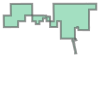

In [8]:
urban_areas['geometry'].iloc[0]

## Begin process

In [9]:
queries = urban_areas.apply(lambda row: {'name':row['NAMELSAD10'],
                                         'geoid':row['GEOID10'],
                                         'name_geoid':'{}_{}'.format(row['NAMELSAD10'], row['GEOID10']).replace(',', '_').replace(' ', '_'),
                                         'polygon':row['geometry']}, axis=1).tolist()
queries[0]

{'geoid': '22987',
 'name': 'Delano, CA Urbanized Area',
 'name_geoid': 'Delano__CA_Urbanized_Area_22987',
 'polygon': <shapely.geometry.multipolygon.MultiPolygon at 0x27dca79c400>}

In [10]:
start_time = time.time()

for query in queries:
    try:
        G = ox.graph_from_polygon(polygon=query['polygon'], network_type=network_type, 
                                  name=query['name_geoid'], retain_all=retain_all)
        ox.save_graph_shapefile(G, filename=query['name_geoid'])
        ox.save_graphml(G, filename='{}.graphml'.format(query['name_geoid']))
    except Exception as e:
        print('{} failed: {}'.format(name, e))
        
print('Finished making graphs in {:,.2f} seconds'.format(time.time() - start_time))

Finished making graphs in 40,495.42 seconds


In [11]:
#45,000 seconds last time